In [1]:
# DIRECTORY SET
import os
import sys
import traceback
from pathlib import Path
base_dir=Path(os.getcwd()).parent.parent
os.chdir(base_dir)
print(os.getcwd())

# ENVIRONMENT VARIABLES
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

# Enable autoreload
%load_ext autoreload
%autoreload 2

# Import custom modules
from destinyapp.models import StreamRecapData

from destinyapp.customlibrary import services
from destinyapp.customlibrary import utils
from destinyapp.customlibrary import controller

import numpy as np
import matplotlib.pyplot as plt

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


# Load Data

In [2]:
# Input parameter
video_id="OqVH_MTBQ6k"

# load data from testing_visualization_annotation_results.json
import json
with open(f"testing_visualization_data_gen.json", "r") as f:
    data_gen=json.load(f)

annotated_results=data_gen["annotated_results"]
major_topics=data_gen["major_topics"]
minor_topics=data_gen["minor_topics"]

stream_recap_data=await utils.get_recap_data(video_id)

plot_segments, category_locations, color_dict = await services.RV.create_segments(stream_recap_data.linked_transcript, annotated_results, major_topics, stream_recap_data.transcript)

# Shove data into class

In [3]:
plot_object=services.RV.PlotObject()

In [4]:
# Define Segments
plot_object.segments=[]
for segment in plot_segments:
    segment["x"]=None
    seg_obj=services.RV.Segment(**segment)
    plot_object.segments.append(seg_obj)

In [5]:
# Define time_normalization
plot_object.time_normalization=services.RV.TimeNormalization(net_duration=plot_object.segments[-1].end-plot_object.segments[0].start, start_offset=plot_object.segments[0].start)

# Define Abstractions
for segment in plot_object.segments:
    abstraction=plot_object.abstractions.get(segment.category, None)
    if abstraction:
        plot_object.abstractions[segment.category].width+=segment.width
    else:
        plot_object.abstractions[segment.category]=services.RV.Abstraction(width=segment.width, color=segment.color, x=None, y=None, size=None)

    segment.x=(((segment.start+segment.end)/2)-plot_object.time_normalization.start_offset)/plot_object.time_normalization.net_duration

# Define circle size
circle_size_multiplier=0.1
circle_size_offset=0.08
def get_circle_size(total_width):
    return (((np.sqrt(total_width) * circle_size_multiplier)*2)+circle_size_offset)

# define abstraction size
total_abstraction_width=0
for category, abstraction in plot_object.abstractions.items():
    if category=="non categorized":
        continue
    abstraction.size=get_circle_size(abstraction.width)
    total_abstraction_width+=abstraction.size

# define abstraction x
abstraction_width_cutoff=0.1
number_of_abstractions=len(plot_object.abstractions.values())
circle_zone_size=1-(abstraction_width_cutoff*2)
between_circle_padding=(circle_zone_size-total_abstraction_width)/(number_of_abstractions-2)

last_x=abstraction_width_cutoff-between_circle_padding

upper_y=0.45
lower_y=0.3
for i, category in enumerate(list(category_locations.keys())):
    if category=="non categorized":
        continue
    plot_object.abstractions[category].x=last_x+(plot_object.abstractions[category].size/2)+between_circle_padding

    last_x=plot_object.abstractions[category].x+(plot_object.abstractions[category].size/2)
    if i%2==0:
        plot_object.abstractions[category].y=upper_y
    else:
        plot_object.abstractions[category].y=lower_y

# Plot it

In [54]:
# Create the plot with a specific gray background
from matplotlib import pyplot as plt
background_color=96

plotting_width=10
plotting_height=10

fig, ax = plt.subplots(figsize=(10, 10))
hex_background_color = '#%02x%02x%02x' % (int(background_color), int(background_color), int(background_color))
fig.patch.set_facecolor(hex_background_color)  # Set figure background to [96, 96, 96]
ax.set_facecolor(hex_background_color)  # Set axes background to [96, 96, 96]
target_plot_width=10

plt.close(fig)

### CREATE BAR

In [55]:
# import defaultdict
from collections import defaultdict

# Plot BAR 
current_x = 0
category_info = defaultdict(lambda: {"total_width": 0, "segments": []})

bar_height = 1.5
bar_height = 1.0

clickable_area_x_offset=0.085
clickable_area_y_offset=0.1
clickable_y_height_multiplier=1.22
clickable_areas=[]
href_base="https://youtu.be/"+video_id+"?t="



for i, segment in enumerate(plot_object.segments):

    # ax.add_patch(plt.Rectangle(((segment.x-segment.width/2)*plotting_width, 0), segment.width, bar_height, 
    #                         facecolor=segment.color, edgecolor='white'))
    
    ax.add_patch(plt.Rectangle((((segment.x-(segment.width/2))*plotting_width), 0), segment.width*plotting_width, bar_height, 
                            facecolor=segment.color, edgecolor='white'))
    current_x += segment.width

    # coord_list=[(current_x)*10, (10-(bar_height*clickable_y_height_multiplier)-clickable_area_y_offset)*10, (current_x+segment.width)*10, 10*(10-clickable_area_y_offset)]
    
    # href=href_base+str(int(segment.start))
    # clickable_area={"alt":href, "title":href, "href":href, "coords": coord_list}
    # clickable_areas.append(clickable_area)

total_width = current_x
print("Total width:", total_width)

Total width: 0.9999999999999998


### CREATE CIRCLES

In [56]:
# Calculate Circle Padding
import numpy as np
circle_zone_size=9
circle_y = 3.5
circle_y = 2.78
circle_size_variable = 0.15
circle_size_variable = 0.13
circle_base_size_variable=0.3
circle_base_size_variable=0.41

# current_x=
circle_x_locations={}
total_circles_width=0
def get_circle_width(total_width):
    return (((np.sqrt(total_width) * circle_size_variable)*2)+circle_base_size_variable)

alterating_bool=False
vertical_offset_value=0.5
vertical_offset_value=0.65

import textwrap

# Add central white circle
central_y = 0.8
central_circle = plt.Circle((plotting_width/2, central_y*plotting_height), 0.25, facecolor='white', edgecolor='black', zorder=12)
ax.add_artist(central_circle)


for category, abstraction in plot_object.abstractions.items():
    print(category, abstraction.width)

    if category == 'non categorized':
        continue

    # Calculate x position for the circle (center of all segments of this category)
    if alterating_bool:
        alterating_bool=False
        vertical_offset=-vertical_offset_value
    else:
        vertical_offset=vertical_offset_value
        alterating_bool=True

    # PLOT CIRCLES
    circle = plt.Circle((abstraction.x*plotting_width, abstraction.y*plotting_width), (abstraction.size/2)*plotting_width, facecolor=abstraction.color, edgecolor='white', zorder=10)
    ax.add_artist(circle)

    # PLOT CIRCLE LABELS, set width to circle size and wrap
    text_wrap=textwrap.fill(category, width=12)
    bubble_font_size_text=14
    if abstraction.color=="yellow":
        ax.text(abstraction.x*plotting_width, abstraction.y*plotting_height, text_wrap, ha='center', va='center', color='black', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')
    else:
        ax.text(abstraction.x*plotting_width, abstraction.y*plotting_height, text_wrap, ha='center', va='center', color='white', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')

    # Make lines to center circle
    ax.plot([abstraction.x*plotting_width, plotting_width/2], [abstraction.y*plotting_height, central_y*plotting_height], color="#FFF", linewidth=3, linestyle='-', alpha=0.7, zorder=9) 

non categorized 0.3298881253904253
minor topics 0.13777045828837525
Biden's Decision Not to Seek Re-election 0.04764609006757908
Kamala Harris as Potential Democratic Nominee 0.10710432165369979
Trump's Actions and Republican Party 0.1358964166051451
Immigration and Asylum Policy 0.10324266000340737
Analysis of Federalist Paper No. 78 0.13845192799136807


In [57]:
# make lines to the circles
for segment in plot_object.segments:
     abstraction=plot_object.abstractions[segment.category]
     if segment.x and abstraction.y:
          ax.plot([segment.x*plotting_width, abstraction.x*plotting_width], [bar_height, abstraction.y*10], color=segment.color, linewidth=1)  


### PLOT

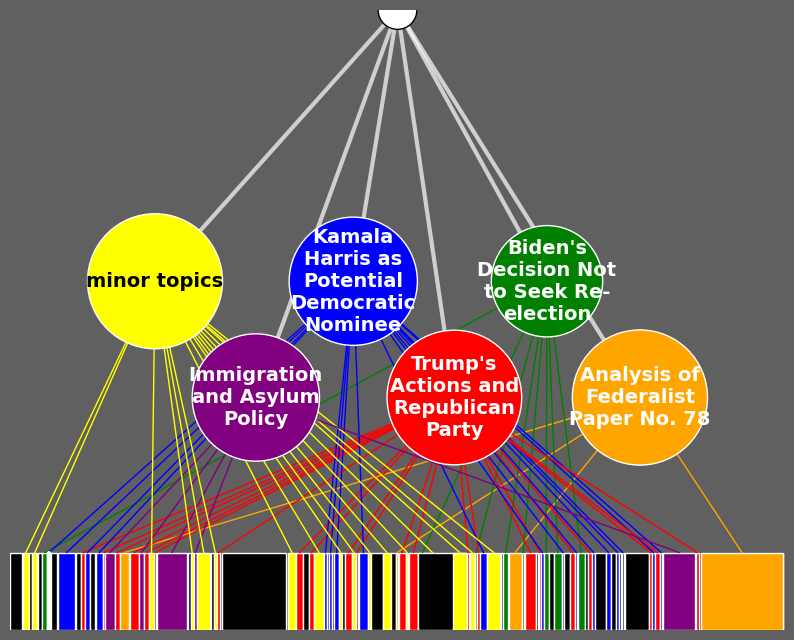

In [58]:
# Add white line extending upward from central circle
top_y = 100  # Adjust this value to change the length of the line
ax.plot([total_width/2, total_width/2], [0, 1], 
        color='white', linewidth=3, solid_capstyle='round')  # Added white line

# Customize the plot
ax.set_xlim(0, total_width*plotting_width)
ax.set_ylim(0, 8)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

# Display the plot
from IPython.display import display

display(fig)